# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import demoji
import re, string
import nltk
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

# Changing Data Columns

In [3]:
# Dataset CSV Paths
training_path = r'C:\Users\chris\Documents\cs5100\CS5100_FinalProject\twitter_training.csv'
testing_path = r'C:\Users\chris\Documents\cs5100\CS5100_FinalProject\twitter_validation.csv'

# Import data
train_data = pd.read_csv(training_path)
test_data = pd.read_csv(testing_path)

# Drop first row to add data labels
train_data.drop(['2401', 'Borderlands'], axis = 1, inplace = True)
test_data.drop(['3364', 'Facebook'], axis = 1, inplace = True)

# Rename labels 
train_data = train_data.rename(columns = {"Positive" : "sentiment", "im getting on borderlands and i will murder you all ," : "text"})
test_data = test_data.rename(columns = {"Irrelevant" : "sentiment", "I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣" : "text"})

# get rid of extra labels
train_data = train_data[~train_data['sentiment'].isin(['Neutral', 'Irrelevant'])].reset_index(drop=True)
test_data = test_data[~test_data['sentiment'].isin(['Neutral', 'Irrelevant'])].reset_index(drop=True)

test_data.head()

,sentiment,text
0,Negative,@Microsoft Why do I pay for WORD when it funct...
1,Negative,"CSGO matchmaking is so full of closet hacking,..."
2,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
3,Positive,Thank you @EAMaddenNFL!! \r\n\r\nNew TE Austin...
4,Positive,"Rocket League, Sea of Thieves or Rainbow Six: ..."


In [4]:
def tweet_to_words(tweet): # Get meaninful words only
    letters_only = re.sub("[^a-zA-Z]", " ",tweet) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))

# Preprocessing

In [5]:
# Remove emojis
def strip_emoji(text):
    return demoji.replace(str(text), r"") #remove emoji. Note: Emojis add sentiment to the text. It's harmful to get rid of that data.

# Remove punctuations, links, mentions and \r\n new line characters
def clean_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters 
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

# Remove hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove hashtags at the end of a tweet
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

# Filter special chars
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

# Remove extra spaces
def remove_spaces(text): 
    return re.sub("\s\s+" , " ", text)

cleaned_train = []
for t in train_data.text.astype(str):
    cleaned_train.append(remove_spaces(filter_chars(clean_hashtags(clean_entities(strip_emoji(t))))))
cleaned_test = []
for t in test_data.text.astype(str):
    cleaned_test.append(remove_spaces(filter_chars(clean_hashtags(clean_entities(strip_emoji(t))))))
train_data['cleaner_text'] = cleaned_train
test_data['cleaner_text'] = cleaned_test
train_data['cleaner_text']=train_data['cleaner_text'].apply(lambda x: tweet_to_words(x))
test_data['cleaner_text']=test_data['cleaner_text'].apply(lambda x: tweet_to_words(x))
train_data['cleaner_text'].head()

0              coming borders kill
1      im getting borderlands kill
2     im coming borderlands murder
3    im getting borderlands murder
4    im getting borderlands murder
Name: cleaner_text, dtype: object

# Wordcloud Positive

In [6]:
data_pos = train_data[train_data['sentiment']=='Positive']
data_pos.head()

,sentiment,text,cleaner_text
0,Positive,I am coming to the borders and I will kill you...,coming borders kill
1,Positive,im getting on borderlands and i will kill you ...,im getting borderlands kill
2,Positive,im coming on borderlands and i will murder you...,im coming borderlands murder
3,Positive,im getting on borderlands 2 and i will murder ...,im getting borderlands murder
4,Positive,im getting into borderlands and i can murder y...,im getting borderlands murder


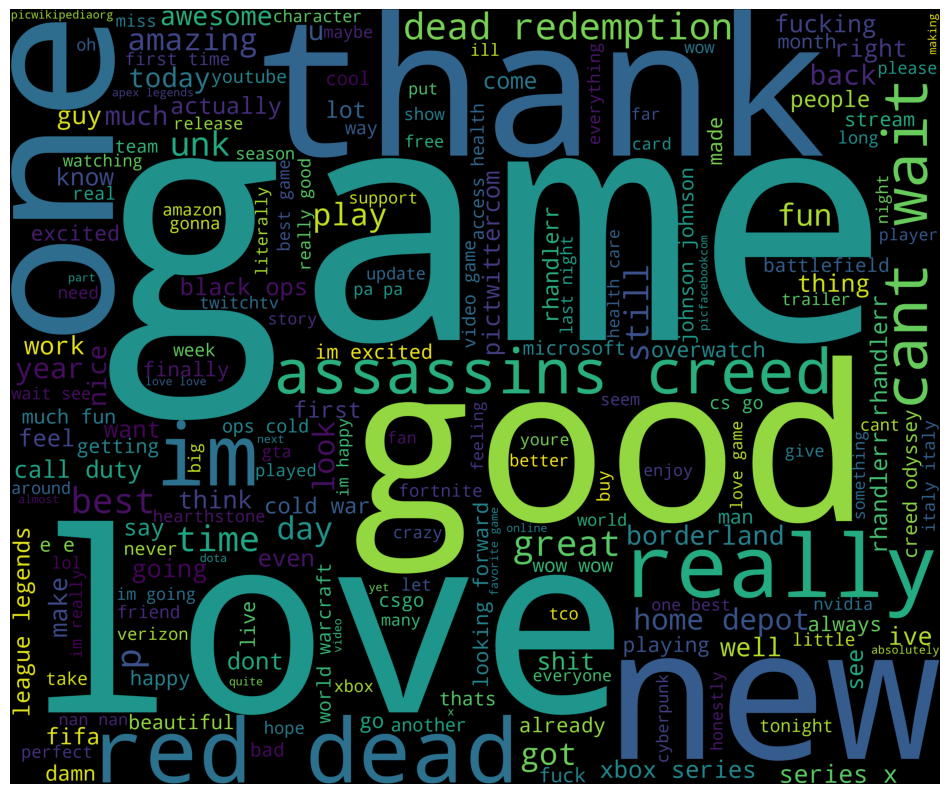

In [7]:
words = ' '.join(str(v) for v in data_pos['cleaner_text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('positive_wordcloud.png')

# Wordcloud Negative

In [8]:
data_neg = train_data[train_data['sentiment']=='Negative']
data_neg.head()

,sentiment,text,cleaner_text
17,Negative,the biggest dissappoinment in my life came out...,biggest dissappoinment life came year ago fuck...
18,Negative,The biggest disappointment of my life came a y...,biggest disappointment life came year ago
19,Negative,The biggest disappointment of my life came a y...,biggest disappointment life came year ago
20,Negative,the biggest dissappoinment in my life coming o...,biggest dissappoinment life coming year ago fu...
21,Negative,For the biggest male dissappoinment in my life...,biggest male dissappoinment life came hanging ...


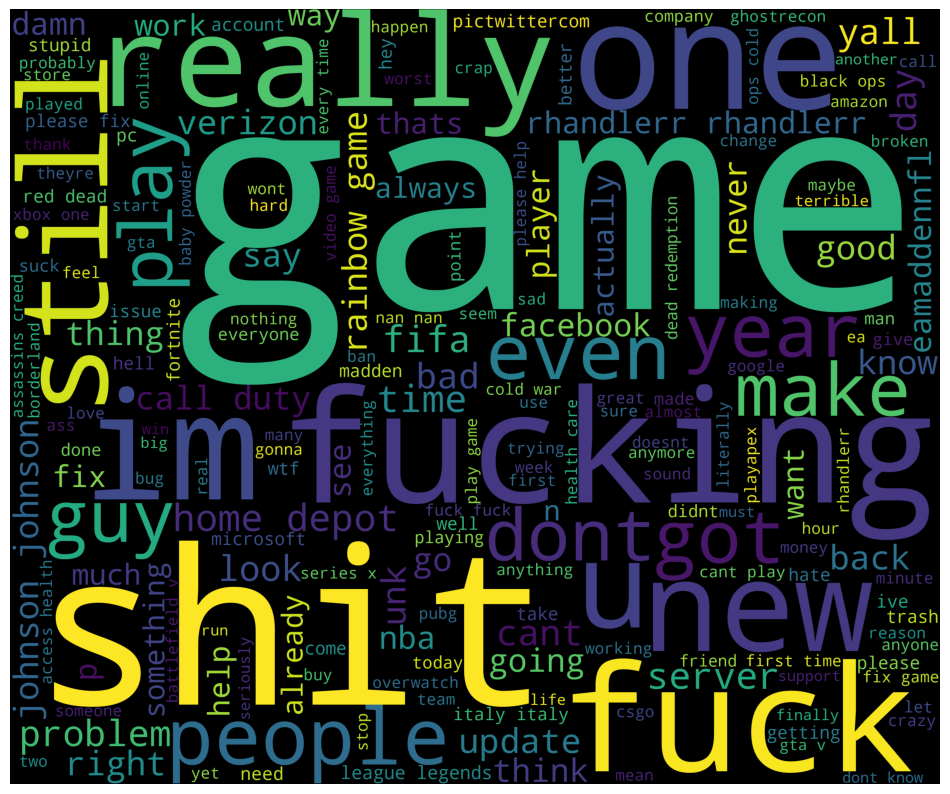

In [9]:
words = ' '.join(str(v) for v in data_neg['cleaner_text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('negative_wordcloud.png')

# Heatmap for Words

In [10]:
data_pos = train_data[train_data['sentiment']=='Positive']
data_pos['temp_list'] = data_pos['cleaner_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in data_pos['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

C:\Users\chris\AppData\Local\Temp\ipykernel_17328\2044505312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['temp_list'] = data_pos['cleaner_text'].apply(lambda x:str(x).split())


,Common_words,count
1,love,1777
2,im,1769
3,good,1618
4,like,1359
5,really,1290
6,new,1199
7,best,1112
8,one,1058
9,play,1047
10,time,999


In [11]:
data_neg = train_data[train_data['sentiment']=='Negative']
data_neg['temp_list'] = data_neg['cleaner_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in data_neg['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

C:\Users\chris\AppData\Local\Temp\ipykernel_17328\3551828624.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['temp_list'] = data_neg['cleaner_text'].apply(lambda x:str(x).split())


,Common_words,count
1,get,1662
2,like,1620
3,shit,1516
4,im,1428
5,fix,1313
6,fuck,1259
7,cant,1229
8,play,1209
9,dont,1127
10,please,1111


# Vectorize

In [12]:
x_train = train_data.cleaner_text # features
y_train = train_data.sentiment # class labels

x_test = test_data.cleaner_text
y_test = test_data.sentiment
print(len(x_train), len(y_train))

43373 43373


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

# Create the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [14]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)

In [15]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)
vect_tunned

CountVectorizer(max_df=0.7, max_features=100, min_df=0.1, ngram_range=(1, 2),
                stop_words='english')

# Model

In [16]:
# Use linear kernel for SKlearn SVM
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state = 10) # Can change the kernel type, default runs for 1000 iterations
model.fit(x_train_dtm, y_train)

SVC(kernel='linear', random_state=10)

In [33]:
# Predict output
pred = model.predict(x_test_dtm)

In [34]:
accuracy_score(y_test,pred)

0.9723756906077348

# Data Metrics 

In [35]:
cm = confusion_matrix(y_test, pred)

In [36]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

    Negative       0.98      0.97      0.97       266
    Positive       0.97      0.98      0.97       277

    accuracy                           0.97       543
   macro avg       0.97      0.97      0.97       543
weighted avg       0.97      0.97      0.97       543



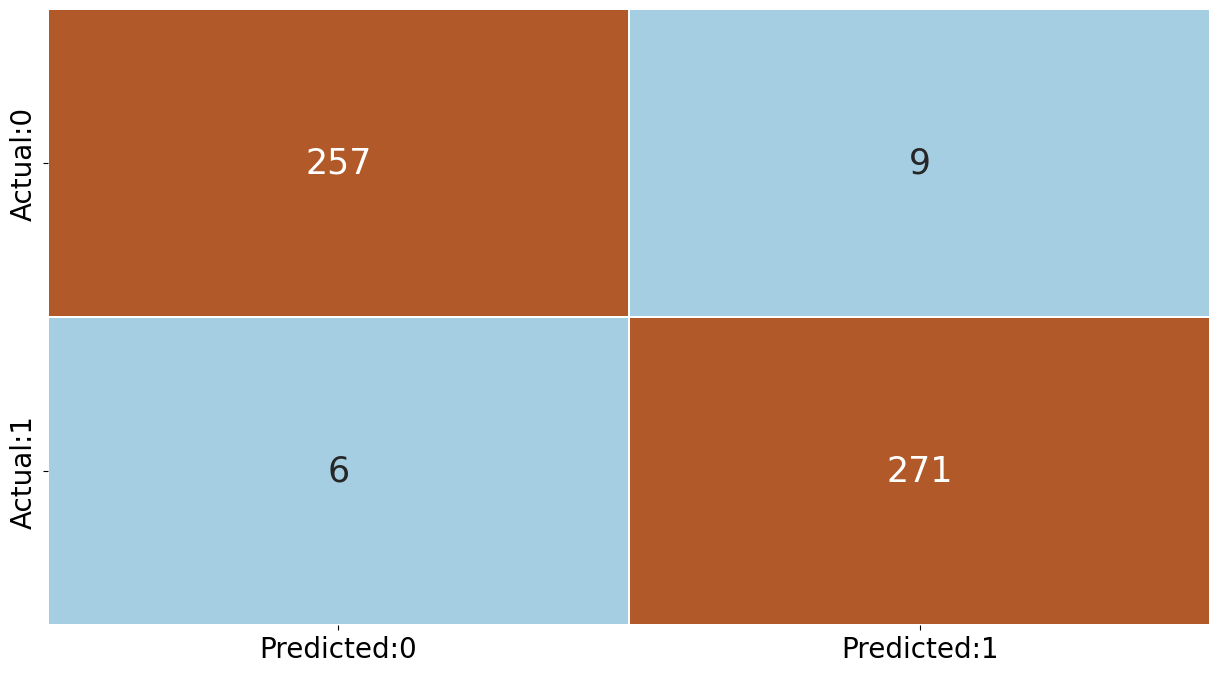

<Figure size 1500x800 with 0 Axes>

In [38]:
# Create plot size for the confusion matrix 
plt.rcParams['figure.figsize'] = [15,8]
#confusion matrix to DataFrame
conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1',], index = ['Actual:0','Actual:1',])
# Create the heatmap for the confusion matrix
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Paired', cbar = False,linewidths = 0.1, annot_kws = {'size':25})
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()
plt.savefig('SVM_cm.png')